In [1]:
# import libraries
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
import glob
import numpy as np
import cv2
import torch
from torchvision import transforms
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Conv3d, AvgPool3d
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AUC, AUROC, Accuracy
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import loggers as pl_loggers
from tqdm import tqdm
# from efficientnet_pytorch_3d import EfficientNet3D
# from torchsummary import summary

# change directory to data folder
PATH_DATA = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification'
# PATH_TEMP = '/kaggle/temp'
os.chdir(PATH_DATA)   

In [2]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b4') 
# summary(model, input_size=(4, 64, 128, 128))

In [3]:
# %load_ext tensorboard
# %tensorboard --logdir logs

### Naming convention
* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)

### Notes:
1. images: `[00109, 00123, 00709]` can be removed from training dataset
2. The images are in .dcm format. We  need to use library `dicom` to read them in

In [4]:
def create_dataset(train:bool=True):
    """Create dataset"""

    if train:
        folder = 'train'
        cases_list = os.listdir(folder)
        train_labels = pd.read_csv('train_labels.csv')
        
    else:
        folder = 'test'
        cases_list = os.listdir(folder)
        
    i = 0
    for case in cases_list:
        if case in ['00109', "00123", "00709"]:
            cases_list.pop(i)
        i += 1
    
    cases_dict = {case: ['T2w', 'T1wCE', 'T1w', 'FLAIR'] for case in cases_list}
    
    for k, v in cases_dict.items():
        idx = 0
        for i in v:
            images = os.listdir(os.path.join(folder, k, i))
            cases_dict[k][idx] = {i: images}
            idx += 1
    

    df = pd.DataFrame(cases_dict).transpose().reset_index()
    df.columns = ['Case', 'T2w', 'T1wCE', 'T1w', 'FLAIR']

    for x, y in df.iterrows():
        df.at[x, 'T2w'] = list(y[1].values())[0]
        df.at[x, 'T1wCE'] = list(y[2].values())[0]
        df.at[x, 'T1w'] = list(y[3].values())[0]
        df.at[x, 'FLAIR'] = list(y[4].values())[0]
    
    if train:
        df['FLAIR Count'] = df['FLAIR'].apply(lambda x: len(x))
        df['T1w Count'] = df['T1w'].apply(lambda x: len(x))
        df['T1wCE Count'] = df['T1wCE'].apply(lambda x: len(x))
        df['T2w Count'] = df['T2w'].apply(lambda x: len(x))
        
        df['CaseInt'] = df['Case'].astype(str).apply(lambda x: x.lstrip('0') if x != '00000' else x).astype(int)
        df = pd.merge(df, train_labels, how = 'inner', left_on = 'CaseInt', right_on = 'BraTS21ID')
        df.drop(columns=['BraTS21ID'], inplace=True)
    
    return df

In [5]:
train_data = create_dataset(train=True)
train_data.sample(3)

,Case,T2w,T1wCE,T1w,FLAIR,FLAIR Count,T1w Count,T1wCE Count,T2w Count,CaseInt,MGMT_value
425,00818,"[Image-4.dcm, Image-2.dcm, Image-3.dcm, Image-...","[Image-4.dcm, Image-2.dcm, Image-3.dcm, Image-...","[Image-4.dcm, Image-2.dcm, Image-3.dcm, Image-...","[Image-3.dcm, Image-23.dcm, Image-5.dcm, Image...",15,29,29,29,818,0
372,00500,"[Image-130.dcm, Image-98.dcm, Image-4.dcm, Ima...","[Image-273.dcm, Image-245.dcm, Image-130.dcm, ...","[Image-273.dcm, Image-245.dcm, Image-130.dcm, ...","[Image-130.dcm, Image-98.dcm, Image-4.dcm, Ima...",208,352,352,208,500,1
240,00300,"[Image-4.dcm, Image-63.dcm, Image-41.dcm, Imag...","[Image-130.dcm, Image-98.dcm, Image-4.dcm, Ima...","[Image-130.dcm, Image-98.dcm, Image-4.dcm, Ima...","[Image-4.dcm, Image-41.dcm, Image-2.dcm, Image...",60,192,192,64,300,0


FLAIR: Min = 15 / Max = 514
T1w: Min = 19 / Max = 400
T1wCE: Min = 19 / Max = 400
T2w: Min = 19 / Max = 472


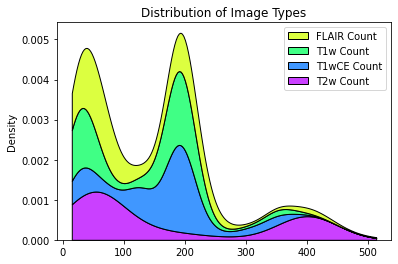

In [6]:
print("============================")
print(f"FLAIR: Min = {min(train_data['FLAIR Count'].tolist())} / Max = {max(train_data['FLAIR Count'].tolist())}")
print("============================")
print(f"T1w: Min = {min(train_data['T1w Count'].tolist())} / Max = {max(train_data['T1w Count'].tolist())}") 
print("============================")
print(f"T1wCE: Min = {min(train_data['T1wCE Count'].tolist())} / Max = {max(train_data['T1wCE Count'].tolist())}") 
print("============================")
print(f"T2w: Min = {min(train_data['T2w Count'].tolist())} / Max = {max(train_data['T2w Count'].tolist())}") 
print("============================")

plt.title('Distribution of Image Types')
counts = train_data[['FLAIR Count', 'T1w Count', 'T1wCE Count', 'T2w Count']]
sns.kdeplot(data=counts, clip=[15, 514], common_norm=True, palette='hsv', multiple='stack')

plt.show()

In [7]:
print("Image Type     IQR")
counts.quantile(.75) - counts.quantile(.25)

Image Type     IQR


FLAIR Count    140.0
T1w Count      160.0
T1wCE Count     63.0
T2w Count      312.0
dtype: float64

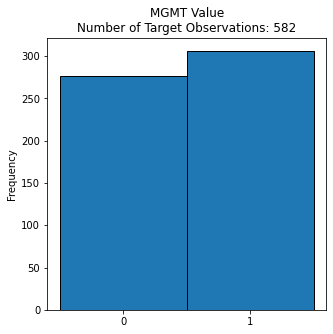

In [8]:
# what's the distribution of targets?
train_data['MGMT_value'].plot(kind='hist', 
                              xticks=((0, 1)), 
                              bins=[-.5,.5,1.5], 
                              title=f'MGMT Value\nNumber of Target Observations: {train_data.count()[1]}', 
                              ec="k", 
                              figsize=(5,5))
plt.show()

In [9]:
class MRIDataset(Dataset):
    def __init__(self, df:pd.DataFrame, train:bool=True, size:int=128, n_images:int=32, transform=None):
        super().__init__()
        self.df = df
        self.train = train
        self.transform = transform
        self.n_images = n_images
        self.size = size
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        target = self.df["MGMT_value"][idx]
        case = self.df["Case"][idx]
        
        flair_list = self.df['FLAIR'][idx]
        t1w_list = self.df['T1w'][idx]
        t1wce_list = self.df['T1wCE'][idx]
        t2w_list = self.df["T2w"][idx]
        
        # CONCATENATE SEQUENCES
        flair_array = self.__create_array(flair_list, case, 'FLAIR')
        t1w_array = self.__create_array(t1w_list, case, 'T1w')
        t1wce_array = self.__create_array(t1wce_list, case, 'T1wCE')
        t2w_array = self.__create_array(t2w_list, case, 'T2w')
        
        if self.transform:
            flair_transformed = self.transform(flair_array)
            t1w_transformed = self.transform(t1w_array)
            t1wce_transformed = self.transform(t1wce_array)
            t2w_transformed = self.transform(t2w_array)
            
            stacked_images = torch.stack(
                [flair_transformed, t1w_transformed, t1wce_transformed, t2w_transformed], 
                axis=0
            ).squeeze() 
                
            
            return stacked_images, target
        else:
            stacked_images = np.stack(
                [flair_array, t1w_array, t1wce_array, t2w_array], 
                axis=0
            )
            
            return stacked_images, target
    
    def __create_array(self, img_list:list, case:str, img_type:str):
        
        array = np.zeros(
            (self.size, self.size, self.n_images*2), 
            dtype=np.uint8
        )
                         
        middle = len(img_list)//2
        lower = max(0, middle-self.n_images)
        upper = min(len(img_list), middle+self.n_images)
                         
        for idx, img in enumerate(img_list[lower:upper]):
            
            if self.train:
                image = pydicom.dcmread(
                    os.path.join(
                        'train', case, img_type, img)
                ).pixel_array
            
            else:
                image = pydicom.dcmread(
                    os.path.join(
                        'test', case, img_type, img)
                ).pixel_array
                
            img_resized = cv2.resize(
                image, 
                (self.size, self.size)
            )
            
            array[:,:,idx] = img_resized
                         
        cropped_img = self.__bbox(array)
        
        img_resized = cv2.resize(
            cropped_img, 
            (self.size, self.size)
        )
        
        return img_resized 
    
    def __bbox(self, img):
        
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)

        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        
        cropped_img = img[ymin:ymax+1, xmin:xmax+1]

        return cropped_img

In [10]:
dataset = MRIDataset(
    df=train_data, 
    transform=transforms.ToTensor()
)

In [11]:
def visualize_dataset(index: int, dataset):
    
    i = np.random.randint(0, 582)
    
    lower_index = index -2
    upper_index = index + 2
    
    image = dataset[i][0][0].permute(1,2,0)
    indexed_image = image[:,:,lower_index:upper_index]
    
    plt.title(dataset[i][1])
    plt.imshow(indexed_image, cmap='gray')
    plt.show()

In [12]:
dataset[0][0].shape

torch.Size([4, 64, 128, 128])

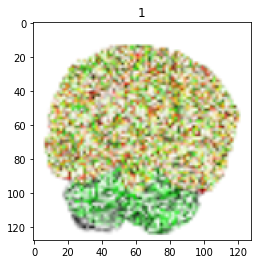

In [13]:
visualize_dataset(10, dataset)

In [14]:
lengths = [int(len(dataset)*0.7+1), int(len(dataset)*0.3)]
train, val = torch.utils.data.dataset.random_split(dataset, lengths)

In [15]:
train_dataloader = DataLoader(train, batch_size=12, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val, batch_size=12, shuffle=False, num_workers=2)

In [16]:
def get_conv_out(img_size: int, kernel: int, stride: int, padding: int):
    return ((img_size - kernel + (padding * 2)) / stride) + 1

In [17]:
def get_output_size(
    img_size: int = 256, 
    conv_kernel: int = 3, 
    conv_stride: int = 1, 
    conv_padding: int = 0, 
    pool: bool = True, 
    pool_kernel: int = 3, 
    pool_stride: int = 3, 
    pool_padding: int = 0,
    n_layers: int = 1
):
    
    for layer in range(1, n_layers+1):
        out_size = int(get_conv_out(img_size, conv_kernel, conv_stride, conv_padding))
        if not pool:
            print(f"Layer {layer}: {out_size}")
        
        if pool:
            img_size = int(get_conv_out(out_size, pool_kernel, pool_stride, pool_padding))
            print(f"Layer {layer}: {img_size}")

In [18]:
get_output_size(img_size=64, conv_kernel=3, conv_stride=1, conv_padding=1, pool=True, pool_kernel=2, pool_stride=2, pool_padding=1, n_layers=5)

Layer 1: 33
Layer 2: 17
Layer 3: 9
Layer 4: 5
Layer 5: 3


In [19]:
get_output_size(img_size=128, conv_kernel=3, conv_stride=1, conv_padding=1, pool=True, pool_kernel=2, pool_stride=2, pool_padding=1, n_layers=5)

Layer 1: 65
Layer 2: 33
Layer 3: 17
Layer 4: 9
Layer 5: 5


In [20]:
# output = (input - kernel_size + (padding*2) / stride) + 1
# output = (128 - 3 + 0 / 3) + 1

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Sequential(
            self.conv_block(4,16,3), ## Conv Output = 62x126x126 --> max pool Output = 31x63x63
            self.conv_block(16,32,3), ## Conv Output = 29x61x61 --> max pool Output = 14x30x30
            self.conv_block(32,64,3), ## Conv Output = 12x28x28 --> max pool Output = 6x14x14
            self.conv_block(64,128,3),
            self.conv_block(128,256,3)
        )
        self.fc = nn.Sequential(
            nn.Linear(19200, 9600),
            torch.nn.BatchNorm1d(9600),
            # nn.Dropout(.2),
            nn.Linear(9600, 4800),
            torch.nn.BatchNorm1d(4800),
            # nn.Dropout(.2),
            nn.Linear(4800, 2400),
            torch.nn.BatchNorm1d(2400),
            # nn.Dropout(.2),
            nn.Linear(2400,1)
        )
    
    def conv_block(self, in_channels, out_channels, kernel):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel, padding=1), # output = 62 x 126 x 126
            nn.LeakyReLU(),
            nn.BatchNorm3d(out_channels),
            nn.MaxPool3d(kernel-1, padding=1)
        )
        return conv_layer
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [21]:
# model = Model()

# PyTorch Implementation

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
criterion = nn.BCEWithLogitsLoss()
roc = AUROC(pos_label = 1)
optimizer = torch.optim.Adam(model.parameters(), lr = .001)
n_epochs = 25
train_loss = []
val_loss = []
train_roc = []
val_roc = []
best_roc = 0.0

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:37: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
for epoch in range(n_epochs):
    total_loss = 0.0
    auroc = 0
    count = 0
    
    model.train()
    for idx,batch in enumerate(train_dataloader, 0):
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(x)
        loss = criterion(outputs.permute(1,0).type(torch.float32), torch.unsqueeze(y, 0).type(torch.float32))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.detach().item()
        
        count += 1
        
    auroc += roc(outputs.squeeze(1).type(torch.float32), y.type(torch.int64))
    print(f"Epoch:{epoch}/{n_epochs} - Train Loss:{total_loss/count} - Train AUROC:{auroc}")
    
    train_loss.append(total_loss)
    train_roc.append(auroc)
        
    
    total_loss = 0.0
    auroc = 0
    count = 0
    
    model.eval()
    for idx,batch in enumerate(val_dataloader, 0):
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        outputs = model(x)
        loss = criterion(outputs.permute(1,0).type(torch.float32), torch.unsqueeze(y, 0).type(torch.float32))
        
        total_loss += loss.detach().item()
        
        count += 1
        
    auroc += roc(outputs.squeeze(1).type(torch.float32), y.type(torch.int64))
    print(f"Epoch:{epoch}/{n_epochs} - Val Loss:{total_loss/count} - Val AUROC:{auroc}")
    
    val_loss.append(total_loss)
    val_roc.append(auroc)
    
    
#     if auroc > best_roc:
#         best_roc = auroc
#         torch.save(model.state_dict(), f'best_roc_{auroc}_loss_{round(total_loss, 2)}.pt')

Epoch:0/25 - Train Loss:0.7489126762923073 - Train AUROC:0.4444444477558136
Epoch:0/25 - Val Loss:0.6931471824645996 - Val AUROC:0.75
Epoch:1/25 - Train Loss:0.7100808900945327 - Train AUROC:0.7285714149475098
Epoch:1/25 - Val Loss:0.7092529892921448 - Val AUROC:0.4375


In [ ]:
# x,y = next(iter(val_dataloader))
# out = model(x)

In [ ]:
# out_permute = out.permute(1,0).type(torch.float32)
# y_expand = torch.unsqueeze(y, 0).type(torch.float32)
# criterion(out_permute, y_expand)

In [ ]:
# roc_labels, roc_output = y.type(torch.int64), out.squeeze(1).type(torch.float32)
# roc(roc_output, roc_labels)

In [ ]:
# class MRIModel(pl.LightningModule):
#     def __init__(self):
#         super().__init__()
#         self.roc = AUROC(num_classes=2)
#         self.loss = nn.BCELoss()
#         self.model = Model()
    
#     def forward(self, x):
#         return self.model(x)
    
#     def training_step(self, train_batch, train_idx):
#         x,y = train_batch
#         out = self(x)
#         pred_round = torch.squeeze(out, 1).round()
#         pred_value = pred_round
#         loss = self.loss(pred_value, y.float())
#         roc = self.roc(pred_value, y)
#         acc = torch.mean(torch.Tensor.float(pred_value == y.float()))
#         logs = {
#             'batch_acc' : acc,
#             'batch_roc' : roc
#         }
        
#         batch_dictionary={
#             "loss": loss,
#             "log": logs
#         }
        
#         return  batch_dictionary
        
    
#     def validation_step (self, val_batch, val_idx):
#         x,y = val_batch
#         out = self.model(x)
#         pred_round = torch.squeeze(out, 1).round()
#         pred_value = pred_round
#         loss = self.loss(pred_value, y.float())
#         acc = torch.mean(torch.Tensor.float(pred_value == y.float()))
#         roc = self.roc(pred_value, y)
#         logs = {
#             'batch_acc' : acc,
#             'batch_roc' : roc
#         }
        
#         batch_dictionary={
#             "loss": loss,
#             "log": logs
#         }
        
#         return  batch_dictionary
    
#     def configure_optimizers(self):
#         opt = torch.optim.Adam(self.parameters(), lr = .01)
#         return opt

In [ ]:
# model_lightning = MRIModel()

In [ ]:
# model_lightning(torch.randn((8,4,64,128,128)))

In [ ]:
# logger=TensorBoardLogger("/kaggle/working/", name='logs')
# trainer = Trainer(max_epochs=3, logger=logger)

In [ ]:
# trainer.fit(model_lightning, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)